<a href="https://colab.research.google.com/github/Simoni2412/Wrinkles-Detection/blob/main/Test_cnn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [294]:
from tensorflow.keras.layers import Conv2D, Conv2D, UpSampling2D, BatchNormalization, ReLU, Multiply, Input, GlobalAveragePooling2D, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, MaxPooling2D, Dropout, Add, ZeroPadding2D
from tensorflow.keras.layers import Concatenate as Concat

In [295]:
# prompt: Load the previous model from h5 file and test dataset has images and maska
from tensorflow.keras.models import load_model
import tensorflow as tf
import numpy as np
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import load_model

# Define your custom loss
# ---- Attention Module ----
def attention_block(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1,1), padding="same")(x)
    phi_g = Conv2D(inter_channels, (1,1), padding="same")(g)
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1,1), padding="same", activation="sigmoid")(act_xg)
    return Multiply()([x, psi])

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc

#from tensorflow.keras.models import load_model

model = load_model(
    '/content/model_yesspatial_noaugment_batch5.h5',
    custom_objects={
        'attention_block': attention_block,
        'dice_loss': dice_loss,
        'combined_loss': combined_loss
    }
)


In [ ]:
import numpy as np
import cv2
import os

# def load_images_from_folder(folder, target_size):
#     images = []
#     for filename in sorted(os.listdir(folder)):
#         img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
#         #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#         enhanced = clahe.apply(gray)
#         filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)
#         image = np.stack([filtered]*3, axis=-1)
#         image = image.astype(np.float32) / 255.0
#         if image is not None:
#             img = cv2.resize(image, target_size)
#             images.append(img)
#     return np.array(images)

def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):
        image = cv2.imread(os.path.join(folder, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


        # Enhancement (CLAHE + bilateral)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)
        #cv2_imshow(enhanced)
        # filtered = cv2.bilateralFilter(enhanced, 9, 75, 75)
        # image = np.stack([filtered]*3, axis=-1)
        #cv2_imshow(image)
        #image = enhanced.astype(np.float32) / 255.0
        normalized = enhanced.astype(np.float32) / 255.0

        # Convert to 3 channels
        image = np.stack([normalized]*3, axis=-1)
        # plt.imshow(image)
        # plt.title("Processed Image with CLAHE")
        # # plt.axis('off')
        # # plt.show()
        image = cv2.resize(image, IMG_SIZE)
        #cv2_imshow((image*255).astype(np.uint8))
        images.append(image)

    return np.array(images)

def load_masks_from_folder(folder, target_size):
    masks = []
    for filename in sorted(os.listdir(folder)):
        mask = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            mask = cv2.resize(mask, target_size)
            masks.append(mask)
    return np.array(masks)

# Set your image size (should match model input)
IMG_SIZE = (256, 256)  # Change if your model uses a different size

test_images = load_images_from_folder('/content/drive/MyDrive/Dataset /Val_images', IMG_SIZE)
test_masks = load_masks_from_folder('/content/drive/MyDrive/Dataset /Val_mask', IMG_SIZE)
test_masks = np.expand_dims(test_masks, axis=-1)  # Add channel dimension if needed

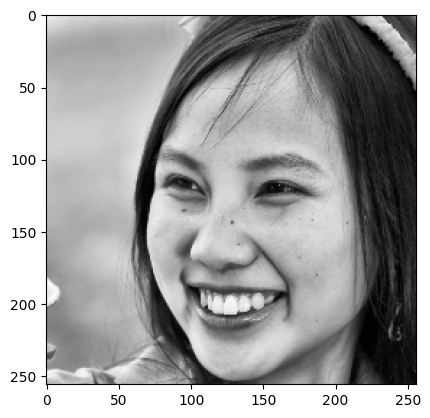

In [297]:

plt.imshow(test_images[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Mean IoU: 0.1522


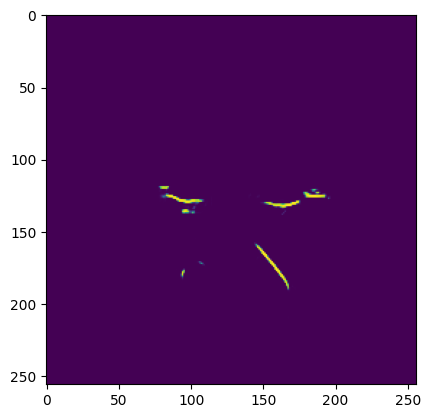

In [298]:
from google.colab.patches import cv2_imshow
# Predict masks
predicted_masks = model.predict(test_images)
plt.imshow(predicted_masks[0])
# Optional: Binarize predictions if needed
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)

# Example: Calculate IoU (Intersection over Union) for evaluation
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

ious = [iou_score(true, pred) for true, pred in zip(test_masks, predicted_masks)]
print(f"Mean IoU: {np.mean(ious):.4f}")

In [299]:
def wrinkle_score(mask):
    # mask should be binary: 1 for wrinkle, 0 for non-wrinkle
    #return np.sum(mask) / mask.size
    score = np.sum(mask) / mask.size
    return np.clip(score * 100, 0, 100)

wrinkle_scores = [wrinkle_score(mask) for mask in predicted_masks]

In [300]:
def wrinkle_score_to_age(score, min_age=20, max_age=80):
    # Example: Assume wrinkle score 0.0 -> min_age, 1.0 -> max_age
    age = min_age + (max_age - min_age) * score
    if age > 60:
      age = 60
    return age


ages = [wrinkle_score_to_age(score) for score in wrinkle_scores]

In [301]:
for i, (score, age) in enumerate(zip(wrinkle_scores, ages)):
    print(f"Image {i+1}: Wrinkle Score = {score:.4f}, Estimated Age = {age:.1f}")

# def wrinkle_scoring(wrinkle_mask):
#     """ Calculate wrinkle score using weighted contrast analysis """
#     score = np.sum(wrinkle_mask) / (wrinkle_mask.shape[0] * wrinkle_mask.shape[1])
#     return np.clip(score * 100, 0, 100)  # Normalize score

def predict_age(wrinkle_score):

    """ Map wrinkle score to estimated age range """
    if wrinkle_score < 20:
        return "20-30 years"
    elif wrinkle_score < 40:
        return "30-40 years"
    elif wrinkle_score < 60:
        return "40-50 years"
    else:
        return "50+ years"

Image 1: Wrinkle Score = 0.3571, Estimated Age = 41.4
Image 2: Wrinkle Score = 0.1480, Estimated Age = 28.9
Image 3: Wrinkle Score = 0.0000, Estimated Age = 20.0
Image 4: Wrinkle Score = 0.6317, Estimated Age = 57.9
Image 5: Wrinkle Score = 0.0885, Estimated Age = 25.3
Image 6: Wrinkle Score = 0.0000, Estimated Age = 20.0
Image 7: Wrinkle Score = 0.1419, Estimated Age = 28.5
Image 8: Wrinkle Score = 0.1877, Estimated Age = 31.3
Image 9: Wrinkle Score = 0.7629, Estimated Age = 60.0
Image 10: Wrinkle Score = 0.1801, Estimated Age = 30.8


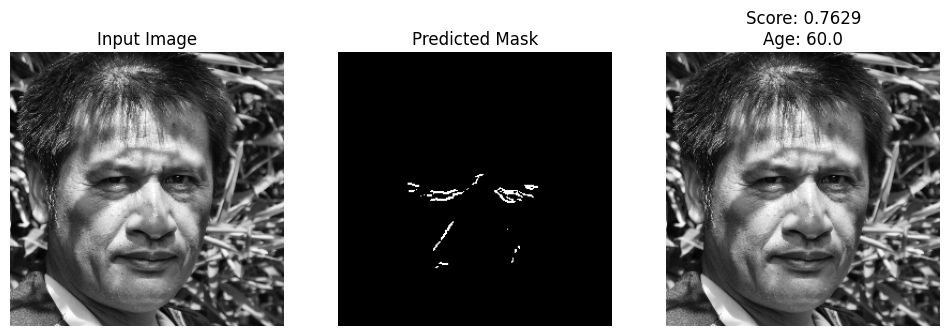

In [302]:
import matplotlib.pyplot as plt

idx = 8  # Change to see other images
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title('Input Image')
#test_images[idx] = test_images.astype(np.float32) / 255.0
plt.imshow(test_images[idx])
plt.axis('off')
plt.subplot(1,3,2)
plt.title('Predicted Mask')
plt.imshow(predicted_masks[idx].squeeze(), cmap='gray')
plt.axis('off')
plt.subplot(1,3,3)
plt.title(f'Score: {wrinkle_scores[idx]:.4f}\nAge: {ages[idx]:.1f}')
plt.imshow(test_images[idx])
plt.axis('off')
plt.show()

In [303]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask_on_image(image, mask, alpha=0.5, mask_color=(255, 0, 0)):
    """
    Overlays a predicted mask on an image.

    Parameters:
    - image: original image, shape (H, W, 3), float32 [0–1] or uint8 [0–255]
    - mask: predicted mask, shape (H, W) or (H, W, 1), float32 [0–1] or uint8
    - alpha: transparency factor for mask overlay
    - mask_color: RGB color for the overlay (default is red)

    Returns:
    - overlayed image (uint8)
    """
    # Convert image to uint8
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Ensure mask is 2D
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    # Resize mask to match image if needed
    if mask.shape != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Normalize mask to [0, 255] and convert to uint8
    if mask.max() <= 1.0:
        mask = (mask * 255).astype(np.uint8)
    else:
        mask = mask.astype(np.uint8)

    # Create a color version of the mask
    color_mask = np.zeros_like(image)
    color_mask[:, :] = mask_color  # e.g., red mask
    color_mask = cv2.bitwise_and(color_mask, color_mask, mask=mask)

    # Overlay
    overlayed = cv2.addWeighted(image, 1.0, color_mask, alpha, 0)

    return overlayed


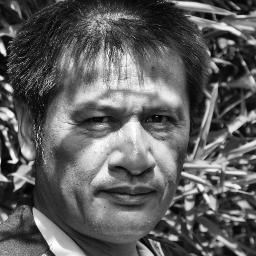

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


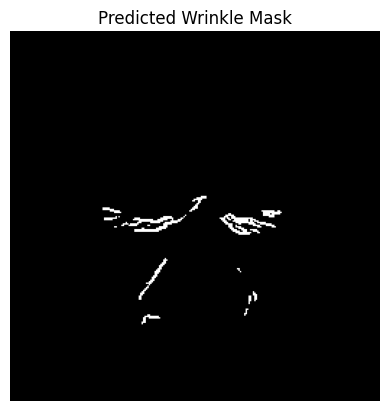

In [307]:
def predict_on_unlabeled(model, image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8,8))
    enhanced = clahe.apply(gray)
    normalized = enhanced.astype(np.float32) / 255.0

    # Convert to 3 channels
    image = np.stack([normalized]*3, axis=-1)

    #img = np.expand_dims(img, axis=0)

    # Ensure IMG_SIZE is a tuple of integers
    image = cv2.resize(image, IMG_SIZE)
    img = np.expand_dims(image, axis=0)

    cv2_imshow((image*255).astype(np.uint8))
    pred = model.predict(img)
    # If model output is (1, 256, 256, 1), squeeze to (256, 256)
    if pred.shape[-1] == 1:
        pred = pred[0, ..., 0]
    else:
        pred = pred[0]
    return pred

# Example usage:
unlabeled_img_path = '/content/drive/MyDrive/Dataset /Val_images/01410.png'
img = cv2.imread(unlabeled_img_path)
pred_mask = predict_on_unlabeled(model, img)
plt.imshow(pred_mask > 0.2, cmap='gray')
plt.title('Predicted Wrinkle Mask')
plt.axis('off')
plt.show()

In [308]:
wrinkle_scores = wrinkle_score(pred_mask)
ages = wrinkle_score_to_age(wrinkle_scores)

In [309]:
wrinkle_scores, ages

(np.float32(0.79182225), 60)

In [310]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_mask_on_image(image, mask, alpha=0.5, mask_color=(255, 0, 0)):
    """
    Overlays a predicted mask on an image.

    Parameters:
    - image: original image, shape (H, W, 3), float32 [0–1] or uint8 [0–255]
    - mask: predicted mask, shape (H, W) or (H, W, 1), float32 [0–1] or uint8
    - alpha: transparency factor for mask overlay
    - mask_color: RGB color for the overlay (default is red)

    Returns:
    - overlayed image (uint8)
    """
    #image = cv2.to
    # Convert image to uint8
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)

    # Ensure mask is 2D
    if mask.ndim == 3:
        mask = mask[:, :, 0]

    # Resize mask to match image if needed
    if mask.shape != image.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Normalize mask to [0, 255] and convert to uint8
    if mask.max() <= 1.0:
        mask = (mask * 255).astype(np.uint8)
    else:
        mask = mask.astype(np.uint8)

    # Create a color version of the mask
    color_mask = np.zeros_like(image)
    color_mask[:, :] = mask_color  # e.g., red mask
    color_mask = cv2.bitwise_and(color_mask, color_mask, mask=mask)

    # Overlay
    overlayed = cv2.addWeighted(image, 1.0, color_mask, alpha, 0)

    return overlayed


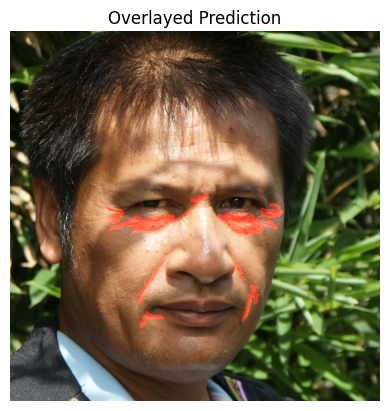

In [311]:
overlay = overlay_mask_on_image(img, pred_mask, alpha=0.5, mask_color=(0, 0, 255))

# Display it
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Overlayed Prediction")
plt.axis('off')
plt.show()